# Preamble

In [1]:
%load_ext autoreload
%autoreload 2

# disable parallelization for BLAS and co.
from nalabtools.utils.parallelization import set_threads_for_external_libraries
set_threads_for_external_libraries(n_threads=1)

# general
import re
import collections
import pickle

# data
import numpy as np
import pandas as pd

# ml / stats
import scipy
import sklearn
import statsmodels.stats.multitest

# plotting
import seaborn as sns
import matplotlib.pyplot as plt

# nalab
import nalabtools

# init notebook files
import nalabtools.utils.misc
nb = nalabtools.utils.misc.NotebookContext("butterfly___martin_003_deepinsight")

In [2]:
import time

In [3]:
def format_duration(totsec):
    h = totsec//3600
    m = (totsec%3600) // 60
    sec =(totsec%3600)%60 #just for reference
    print("%dh %dm %ds" %(h,m,sec))

In [4]:
import rpy2
rpy2.__version__

'3.1.0'

In [5]:
%load_ext rpy2.ipython

/home/mgbckr/miniconda3/envs/analysis3.7/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:14: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex


In [6]:
%%R
R.home()

[1] "/home/mgbckr/miniconda3/envs/analysis3.7/lib/R"


# Load data

In [7]:
import pathlib
import nalabdata.fcs.load
import nalabdata.fcs.meta

In [8]:
# immune clock
tmp_fcs_path = pathlib.Path(nb.file("tmp_fcs_immuneclock.pickle"))
if tmp_fcs_path.exists():

    print("Loading from temp file")
    data_immuneclock_meta, data_immuneclock_fcs = pickle.load(open(path, "rb"))
    
else:
    
    print("Loading from FCS files; this may take a while ...")
    
    path = pathlib.Path("../data/_large/fcs/immune_clock/AllImmuneClock")
    files = list((path / "Training").glob("*")) + list((path / "Validation").glob("*"))

    selected_files = files
    data_immuneclock_meta = nalabdata.fcs.meta.meta_from_filenames(selected_files, context="immune_clock")
    data_immuneclock_fcs = nalabdata.fcs.load.load_fcs(
        selected_files,  
        cell_filter="granulocytes", 
        n_cells_sample=10000,
        n_jobs=64)
    
    pickle.dump((data_immuneclock_meta, data_immuneclock_fcs), open(tmp_fcs_path, "wb"))

Loading from FCS files; this may take a while ...


R[write to console]: Loading required package: foreach

R[write to console]: Loading required package: iterators

R[write to console]: Loading required package: parallel

R[write to console]: 
Attaching package: ‘dplyr’


R[write to console]: The following object is masked from ‘package:flowCore’:

    filter


R[write to console]: The following objects are masked from ‘package:stats’:

    filter, lag


R[write to console]: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


R[write to console]: 

R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In .getGeneric(f, where, package) :
R[write to console]: 
 
R[write to console]:  input string 'unable to find an inherited method for function ‘spillover’ for signature.*(flowSet|ncdfFlowSet)' cannot be translated to UTF-8, is it valid in 'ANSI_X3.4-1968'?

R[write to console]: 2: 
R[write to console]: In .getGeneric(f, where, package) :
R[write to console]: 
 


RRuntimeError: 

## AFCS

In [8]:
import nalabafcs.automate.run.steps
import pathlib
path = pathlib.Path(nb.file("fcs_temp.pickle"))
if path.exists():
    print("Loading from temp file")
    data_fcs = pickle.load(open(path, "rb"))
else:
    print("Loading from FCS files")
    data_fcs = nalabafcs.automate.run.steps.load_fcs(n_jobs=100)
pickle.dump(data_fcs, open(path, "wb"))

/home/mgbckr/mnt/nalab/workspaces/nalab-tools/src/nalabtools/utils/parallelization.py:48: UserWarning: This function should be called before `numpy` or similar modules are imported.
  warnings.warn("This function should be called before `numpy` or similar modules are imported.")


Loading from temp file


In [9]:
data_fcs.shape

(840000, 41)

In [451]:
data_fcs.index.unique().shape[0] / 4

21.0

# Normalization

In [9]:
preprocessing = sklearn.preprocessing.MinMaxScaler().fit(data_fcs.features)
data_features = preprocessing.transform(data_fcs.features.values.copy(order="C"))

# Test embeddings

Embedding packages:
* https://github.com/DmitryUlyanov/Multicore-TSNE
* https://github.com/pavlin-policar/openTSNE
* https://github.com/CannyLab/tsne-cuda
* https://github.com/lmcinnes/umap
* https://github.com/eamid/trimap

In [7]:
test_data = data_features

## UMAP

In [61]:
import umap
umap.__version__

'0.3.10'

In [47]:
start = time.time()
embedding_umap = umap.UMAP().fit_transform(test_data)
duration_um = time.time() - start

/home/mgbckr/miniconda3/envs/analysis3.7/lib/python3.7/site-packages/numba/typed_passes.py:271: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../miniconda3/envs/analysis3.7/lib/python3.7/site-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  state.func_ir.loc))
/home/mgbckr/miniconda3/envs/analysis3.7/lib/python3.7/site-packages/umap/nndescent.py:92: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "..

In [84]:
format_duration(duration_um)

0h 49m 48s


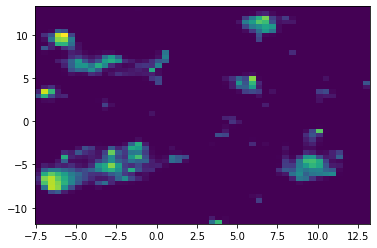

In [49]:
plt.hist2d(embedding_umap[:,0], embedding_umap[:,1], bins=50, );

## Multicore TSNE

In [54]:
import MulticoreTSNE
# MulticoreTSNE.__version__

In [55]:
# %%time
# tsne = MulticoreTSNE.MulticoreTSNE(n_jobs=1)
# embedding = tsne.fit_transform(test_data)

In [ ]:
start = time.time()
embedding_mt = MulticoreTSNE.MulticoreTSNE(n_jobs=100).fit_transform(test_data)
duration_mt = time.time() - start

In [85]:
format_duration(duration_mt)

1h 34m 24s


In [ ]:
plt.hist2d(embedding_mt[:,0], embedding_mt[:,1], bins=50, );

## openTSNE

**WARNING**: seems to hang the kernel at least with pynndescent-0.3.3 ... let's try 0.4.6 which worked on my laptop ... nope, also hangs the kernel ... wtf???

In [50]:
import openTSNE
openTSNE.__version__

'0.3.12'

In [51]:
start = time.time()
embedding_ot = openTSNE.TSNE(n_jobs=100).fit(test_data)
duration_ot = time.time() - start

In [86]:
format_duration(duration_ot)

0h 21m 18s


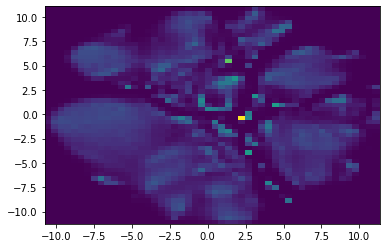

In [53]:
plt.hist2d(embedding_ot[:,0], embedding_ot[:,1], bins=50, );

## FitSNE

**WARNING**: kills the kernel if `n < m`


In [34]:
import fitsne

In [35]:
start = time.time()
embedding_ft = fitsne.FItSNE(np.ascontiguousarray(test_data), nthreads=100)
duration_ft = time.time() - start

In [87]:
format_duration(duration_ft)

0h 17m 15s


In [ ]:
plt.hist2d(embedding_ft[:,0], embedding_ft[:,1], bins=40, );

## Trimap

In [38]:
import trimap
trimap.__version__

'1.0.13'

In [39]:
start = time.time()
embedding_tm = trimap.TRIMAP().fit_transform(test_data)
duration_tm = time.time() - start

TRIMAP(n_inliers=10, n_outliers=5, n_random=5, distance=euclidean,lr=1000.0, n_iters=400, weight_adj=500.0, apply_pca=True, opt_method=dbd, verbose=True, return_seq=False)
running TriMap on 840000 points with dimension 37
pre-processing
found nearest neighbors
sampled triplets
running TriMap with dbd
Iteration:  100, Loss: 18862.326, Violated triplets: 0.0408
Iteration:  200, Loss: 16833.502, Violated triplets: 0.0364
Iteration:  300, Loss: 15701.461, Violated triplets: 0.0340
Iteration:  400, Loss: 14985.802, Violated triplets: 0.0324
Elapsed time: 0:41:27.672711


In [88]:
format_duration(duration_tm)

0h 41m 27s


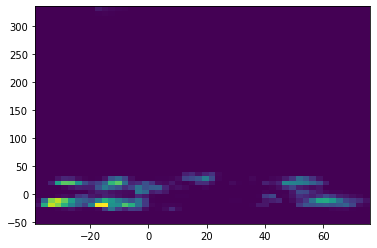

In [41]:
plt.hist2d(embedding_tm[:,0], embedding_tm[:,1], bins=50, );

## PCA

In [42]:
import sklearn.decomposition
sklearn.__version__

'0.22.1'

In [43]:
start = time.time()
embedding_pca = sklearn.decomposition.PCA(n_components=2).fit_transform(test_data)
duration_pca = time.time() - start

In [89]:
format_duration(duration_pca)

0h 0m 4s


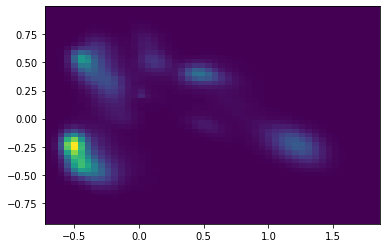

In [45]:
plt.hist2d(embedding_pca[:,0], embedding_pca[:,1], bins=50, );

## Kernel PCA

**WARNING**: Memory error for > 100000 samples

In [91]:
import sklearn.decomposition
sklearn.__version__

'0.22.1'

In [99]:
start = time.time()
embedding_kp = sklearn.decomposition.KernelPCA(n_components=2, kernel="rbf").fit_transform(test_data[:1000,:])
duration_kp = time.time() - start

In [100]:
format_duration(duration_kp)

0h 0m 0s


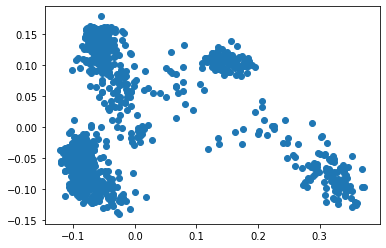

In [101]:
plt.scatter(embedding_kp[:,0], embedding_kp[:,1])

# Test single cell album transformer

Embedding


group:     0, row:   8, col:  38: : 0it [00:00, ?it/s]

Rotating
Images


group:     2, row:  39, col:  39: : 3it [00:02,  1.11it/s]


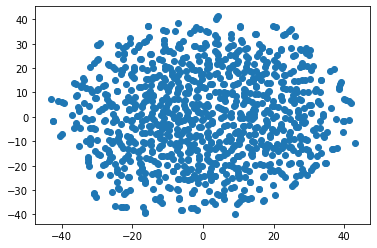

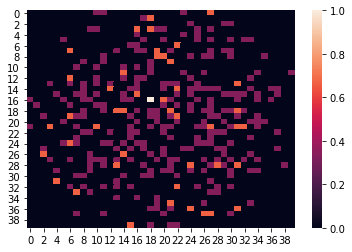

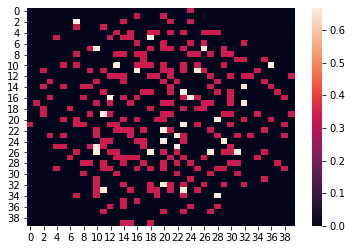

In [43]:
import numpy as np
from sklearn.manifold import TSNE
X = np.array([[0, 0, 0], [0, 1, 1], [1, 0, 1], [1, 1, 1]])
X = np.random.random((1000, 20))
groups = np.random.choice([1,2,3], 1000)

import butterfly.deepinsight.album2
t =butterfly.deepinsight.album2.SingleCellTransformer(size=40, store_embeddings=True)
X_album = t.fit_transform(X, groups)

plt.scatter(t.X_embedded_[:,0], t.X_embedded_[:,1])
plt.figure()
plt.scatter(t.X_rotated_[:,0], t.X_rotated_[:,1])
sns.heatmap(X_album[0, 0, :])
plt.figure()
sns.heatmap(X_album[1, 0, :])

# Incremental single cell transformer

In [463]:
import numpy as np
from sklearn.manifold import TSNE
# X = np.array([[0, 0, 0], [0, 1, 1], [1, 0, 1], [1, 1, 1]])
X = np.random.random((1000, 20))
groups = np.random.choice([1,2,3], 1000)

import butterfly.deepinsight.album2
t = butterfly.deepinsight.album2.SingleCellTransformer(size=40, store_embeddings=True, means=True)
X_album = t.fit_transform(X, groups)

Embedding


group:     0, row:   0: : 0it [00:00, ?it/s]/home/mgbckr/mnt/nalab/workspaces/nalab-butterfly/src/butterfly/deepinsight/album2.py:220: RuntimeWarning: Mean of empty slice.
  if self.means:
/home/mgbckr/miniconda3/envs/analysis3.7/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
group:     1, row:  18: : 1it [00:00,  7.42it/s]

Rotating
Images


group:     2, row:  39: : 3it [00:00,  7.34it/s]


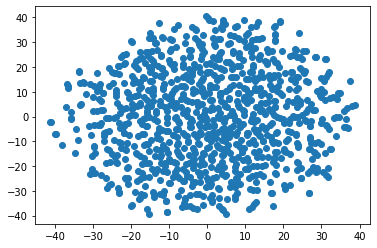

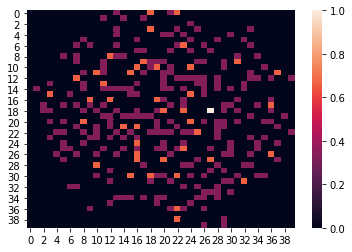

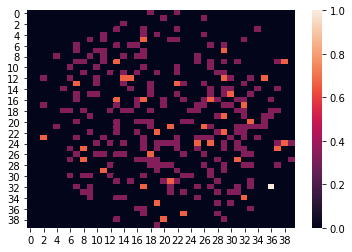

In [464]:
plt.scatter(t.X_embedded_[:,0], t.X_embedded_[:,1])
plt.figure()
plt.scatter(t.X_rotated_[:,0], t.X_rotated_[:,1])
sns.heatmap(X_album[0, 0, :])
plt.figure()
sns.heatmap(X_album[1, 0, :])

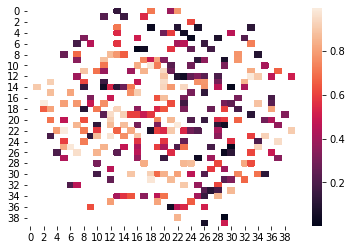

In [487]:
sns.heatmap(X_album[0,1,:])

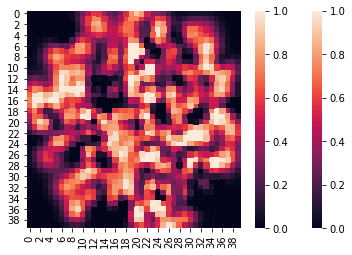

In [511]:
def get_values(level=1):
    for i in range(X_album.shape[2]):
        for j in range(X_album.shape[3]):
            value = X_album[0, level, i, j]
            if not np.isnan(value):
                yield i, j, value

dim = 3
values = list(get_values(level=dim))
x = [x for x, _, _ in values]
y = [y for _, y, _ in values]
d = [d for _, _, d in values]
inter = scipy.interpolate.Rbf(x, y, d, smooth=0, function="gaussian")  # always goes through nodal points

array = np.empty(X_album.shape[2:])
for i in range(X_album.shape[2]):
    for j in range(X_album.shape[3]):
        array[i, j] = inter([i], [j])

sns.heatmap(array, vmin=0, vmax=1)
sns.heatmap(X_album[0,dim,:], vmin=0, vmax=1)

# Test Skorch

In [519]:
import numpy as np
from sklearn.datasets import make_classification
from torch import nn
import torch.nn.functional as F

from skorch import NeuralNetClassifier


X, y = make_classification(1000, 20, n_informative=10, random_state=0)
X = X.astype(np.float32)
y = y.astype(np.int64)

class MyModule(nn.Module):
    def __init__(self, num_units=10, nonlin=F.relu):
        super(MyModule, self).__init__()

        self.dense0 = nn.Linear(20, num_units)
        self.nonlin = nonlin
        self.dropout = nn.Dropout(0.5)
        self.dense1 = nn.Linear(num_units, 10)
        self.output = nn.Linear(10, 2)

    def forward(self, X, **kwargs):
        X = self.nonlin(self.dense0(X))
        X = self.dropout(X)
        X = F.relu(self.dense1(X))
        X = F.softmax(self.output(X), dim=-1)
        return X


net = NeuralNetClassifier(
    MyModule,
    max_epochs=10,
    lr=0.1,
    # Shuffle training data on each epoch
    iterator_train__shuffle=True,
)

net.fit(X, y)
y_proba = net.predict_proba(X)

/home/mgbckr/miniconda3/envs/analysis3.7/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.7049       0.5500        0.6803  0.1550
      2        0.6804       0.5850        0.6700  0.0237
      3        0.6642       0.6500        0.6585  0.0205
      4        0.6416       0.6300        0.6465  0.0208
      5        0.6288       0.6350        0.6371  0.0205
      6        0.6218       0.6550        0.6242  0.0202
      7        0.6084       0.7000        0.6159  0.0199
      8        0.6056       0.7150        0.6044  0.0199
      9        0.5913       0.7100        0.5982  0.0199
     10        0.5858       0.7250        0.5829  0.0201


# Derive images and dataset

In [512]:
# sklearn.preprocessing.LabelEncoder().fit_transform(data_fcs.index.values)
# data_fcs.index.values == data_fcs.index.values[0]
# data_fcs.index.factorize()

In [513]:
import fitsne
import butterfly.deepinsight.album2

start = time.time()

t = butterfly.deepinsight.album2.SingleCellTransformer(
    size=40, 
    embedding_algorithm=lambda X: fitsne.FItSNE(np.ascontiguousarray(X), nthreads=100),
#     embedding_algorithm=None,
    store_embeddings=True)
X_album = t.fit_transform(data_features, data_fcs.index.factorize()[0])

duration = time.time() - start

Embedding
Rotating


group:     0, row:  29: : 0it [00:00, ?it/s]

Images


group:    83, row:  39: : 84it [00:22,  3.75it/s]


In [514]:
format_duration(duration)

0h 14m 33s


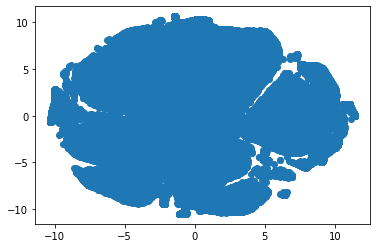

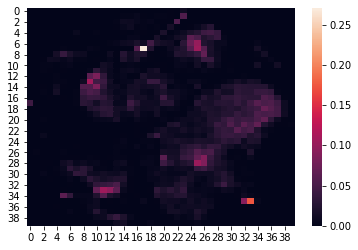

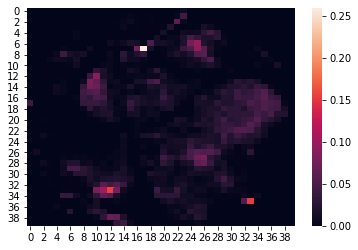

In [515]:
plt.scatter(t.X_embedded_[:,0], t.X_embedded_[:,1])
plt.figure()
plt.scatter(t.X_rotated_[:,0], t.X_rotated_[:,1])
sns.heatmap(X_album[0, 0, :])
plt.figure()
sns.heatmap(X_album[1, 0, :])

In [106]:
# t1 / t2 task
select_t1_t2 = np.array([b in [1,2] for a,b in data_fcs.index.drop_duplicates().values])
X_album_t1_t2 = X_album[select_t1_t2,:]
y_t1_t2 = np.array([b == 2 for _,b in data_fcs.index.drop_duplicates().values[select_t1_t2]])
groups_t1_t2 = np.array([a for a,_ in data_fcs.index.drop_duplicates().values[select_t1_t2]])

In [423]:
import nalabtools.sklearn.model_selection

X = X_album_t1_t2
y = y_t1_t2
groups = groups_t1_t2

splits_test = sklearn.model_selection.GroupShuffleSplit(n_splits=1, test_size=0.10).split(X.reshape(X.shape[0], -1), y, groups=groups)
# splits_test = sklearn.model_selection.StratifiedShuffleSplit(n_splits=1, test_size=0.10).split(X.reshape(X.shape[0], -1), y, groups=groups)
remain_idx, test_idx = next(splits_test)

X_remain = X[remain_idx,:]
y_remain = y[remain_idx]
groups_remain = groups[remain_idx]

X_test = X[test_idx,:]
y_test = y[test_idx]

splits_val = sklearn.model_selection.GroupShuffleSplit(n_splits=1, test_size=0.10).split(X_remain.reshape(X_remain.shape[0], -1), y_remain, groups=groups_remain)
# splits_val = sklearn.model_selection.StratifiedShuffleSplit(n_splits=1, test_size=0.10).split(X_remain.reshape(X_remain.shape[0], -1), y_remain, groups=groups_remain)
train_idx, val_idx = next(splits_val)

# X_train = X_remain[train_idx, :]
# y_train = y_remain[train_idx]
X_train = X_remain
y_train = y_remain
X_val = X_test
y_val = y_test

In [424]:
import torch.utils.data
dataset_train = butterfly.deepinsight.album2.AlbumDataset(X_train, y_train)
dataset_val = butterfly.deepinsight.album2.AlbumDataset(X_val, y_val)
dataset_test = butterfly.deepinsight.album2.AlbumDataset(X_test, y_test)

In [425]:
bs = 10
dataloader_train = torch.utils.data.DataLoader(
    dataset_train, batch_size=bs, shuffle=True, num_workers=2)
dataloader_val = torch.utils.data.DataLoader(
    dataset_val, batch_size=bs * 2)
dataloader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=bs * 2)

# Network

In [426]:
import torch.optim as optim
import butterfly.deepinsight.deepinsight
from tqdm import tqdm
import torchvision
from torch.utils.tensorboard import SummaryWriter

In [427]:
writer = SummaryWriter(nb.folder('runs/singel_cell_16'))

In [428]:
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

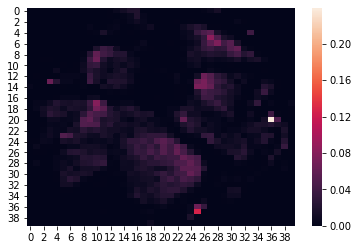

In [429]:
sns.heatmap(X_train[0,0,:])

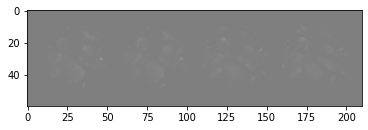

In [430]:
img_grid = torchvision.utils.make_grid(torch.from_numpy(X_train[:4,[0],:,:]), padding=10)
writer.add_image('test_image', img_grid)
matplotlib_imshow(img_grid)

In [431]:
import butterfly.deepinsight.deepinsight
m = butterfly.deepinsight.deepinsight.DeepInsight(
    input_dim=X_train.shape[2:],
    kernel_size1=1, kernel_size2=2, n_initial_filters=1)


# dataiter = iter(dataloader_train)
# images, labels = dataiter.next()

# writer.add_graph(m, images[:4,:])
# writer.flush()

In [432]:
# # embeddings
# # Bugfix: https://github.com/pytorch/pytorch/issues/30966
# import tensorflow as tf
# import tensorboard as tb
# tf.io.gfile = tb.compat.tensorflow_stub.io.gfile

# features = images.view(-1, 40 * 40)
# writer.add_embedding(features,
#                     metadata=labels,
#                     label_img=images.unsqueeze(1))
# writer.close()

In [433]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.SGD(m.parameters(), lr=0.001, momentum=0.9, )
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=64, shuffle=True)

pbar = tqdm(range(500))
for epoch in pbar:  # loop over the dataset multiple times

    m.train()
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(dataloader_train):
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = m(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        every = 1
        if i % every == every - 1:
            
            m.eval()
            
            with torch.no_grad():
                loss_val = sum(criterion(m(x), y) for x, y in dataloader_val)
                loss_val /= len(dataloader_val)
                
            loss_train = running_loss / every
            writer.add_scalars("loss", dict(train=loss_train, validation=loss_val), epoch * len(dataloader_train) + i)
            running_loss = 0.0
            
            pbar.set_description(f"Processing [epoch={epoch}, batch={i:2d}] training_loss={running_loss / every:.03f}")
            
            m.train()
        
            
print('Finished Training`')

Processing [epoch=499, batch= 0] training_loss=0.000: 100%|██████████| 500/500 [00:22<00:00, 22.68it/s]

Finished Training`


In [434]:
X_train.shape

(36, 1, 40, 40)

In [435]:
X_test.shape

(6, 1, 40, 40)

# Evaluation

In [436]:
y_pred_proba = m(torch.tensor(X_train).float())
y_pred = np.argmax(y_pred_proba.detach().numpy(), axis=1)
print(sklearn.metrics.accuracy_score(y_train, y_pred))
print(sklearn.metrics.roc_auc_score(y_train, y_pred_proba[:,1].detach()))

0.5555555555555556
0.6604938271604939


In [437]:
y_pred_proba = m(torch.tensor(X_val).float())
y_pred = np.argmax(y_pred_proba.detach().numpy(), axis=1)
print(sklearn.metrics.accuracy_score(y_val, y_pred))
print(sklearn.metrics.roc_auc_score(y_val, y_pred_proba[:,1].detach()))

0.6666666666666666
0.6666666666666667


In [438]:
y_pred_proba = m(torch.tensor(X_test).float())
y_pred = np.argmax(y_pred_proba.detach().numpy(), axis=1)
print(sklearn.metrics.accuracy_score(y_test, y_pred))
print(sklearn.metrics.roc_auc_score(y_test, y_pred_proba[:,1].detach()))

0.6666666666666666
0.6666666666666667


In [439]:
import sklearn.ensemble
rf = sklearn.ensemble.RandomForestClassifier(n_estimators=100)
rf.fit(X_train.reshape(X_train.shape[0], -1), y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [440]:
print(sklearn.metrics.accuracy_score(y_train, rf.predict(X_train.reshape(X_train.shape[0], -1))))
print(sklearn.metrics.roc_auc_score(y_train, rf.predict_proba(X_train.reshape(X_train.shape[0], -1))[:,1]))

1.0
1.0


In [441]:
print(sklearn.metrics.accuracy_score(y_val, rf.predict(X_val.reshape(X_val.shape[0], -1))))
print(sklearn.metrics.roc_auc_score(y_val, rf.predict_proba(X_val.reshape(X_val.shape[0], -1))[:,1]))

0.3333333333333333
0.4444444444444445


In [442]:
print(sklearn.metrics.accuracy_score(y_test, rf.predict(X_test.reshape(X_val.shape[0], -1))))
print(sklearn.metrics.roc_auc_score(y_test, rf.predict_proba(X_test.reshape(X_val.shape[0], -1))[:,1]))

0.3333333333333333
0.4444444444444445


In [443]:
import sklearn.ensemble
rf = sklearn.ensemble.RandomForestClassifier(n_estimators=100)
rf.fit(
    np.concatenate([X_train.reshape(X_train.shape[0], -1), X_val.reshape(X_val.shape[0], -1)]), 
    np.concatenate([y_train, y_val]))

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [444]:
print(sklearn.metrics.accuracy_score(y_train, rf.predict(X_train.reshape(X_train.shape[0], -1))))
print(sklearn.metrics.roc_auc_score(y_train, rf.predict_proba(X_train.reshape(X_train.shape[0], -1))[:,1]))

1.0
1.0


In [445]:
print(sklearn.metrics.accuracy_score(y_val, rf.predict(X_val.reshape(X_val.shape[0], -1))))
print(sklearn.metrics.roc_auc_score(y_val, rf.predict_proba(X_val.reshape(X_val.shape[0], -1))[:,1]))

1.0
1.0


In [446]:
print(sklearn.metrics.accuracy_score(y_test, rf.predict(X_test.reshape(X_val.shape[0], -1))))
print(sklearn.metrics.roc_auc_score(y_test, rf.predict_proba(X_test.reshape(X_val.shape[0], -1))[:,1]))

1.0
1.0


# Skorch

In [1]:
import numpy as np
from sklearn.datasets import make_classification
from torch import nn
import torch.nn.functional as F

from skorch import NeuralNetClassifier


X, y = make_classification(1000, 20, n_informative=10, random_state=0)
X = X.astype(np.float32)
y = y.astype(np.int64)

class MyModule(nn.Module):
    def __init__(self, num_units=10, nonlin=F.relu):
        super(MyModule, self).__init__()

        self.dense0 = nn.Linear(20, num_units)
        self.nonlin = nonlin
        self.dropout = nn.Dropout(0.5)
        self.dense1 = nn.Linear(num_units, 10)
        self.output = nn.Linear(10, 2)

    def forward(self, X, **kwargs):
        X = self.nonlin(self.dense0(X))
        X = self.dropout(X)
        X = F.relu(self.dense1(X))
        X = F.softmax(self.output(X), dim=-1)
        return X


butterfly.deepinsight.deepinsight.DeepInsight(
    input_dim=X_train.shape[2:],
    kernel_size1=1, kernel_size2=2, n_initial_filters=1)
    
net = NeuralNetClassifier(
    butterfly.deepinsight.deepinsight.DeepInsight,
    max_epochs=10,
    lr=0.1,
    # Shuffle training data on each epoch
    iterator_train__shuffle=True,
)

net.fit(X, y)
y_proba = net.predict_proba(X)

/home/mgbckr/miniconda3/envs/analysis3.7/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


NameError: name 'butterfly' is not defined